### 1. Why LSTM?

A traditional RNN that takes multiple time steps into account for giving predictions can be visualized as follows:

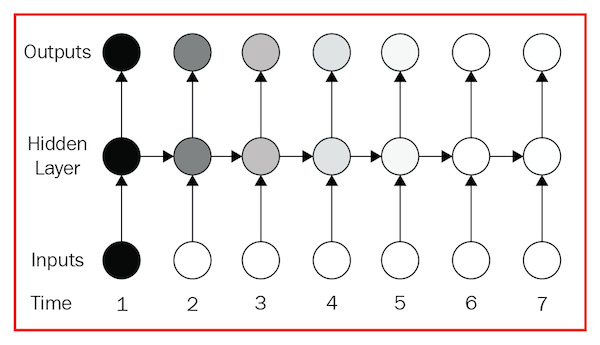

Notice that, as time step increases, the impact of input at a much earlier layer would be lower. An intuition of that can be seen here (for a moment, let's ignore the bias terms):
$$h_5 = WX_5 + Uh_4 = WX_5 + UWX_4 + U_2WX_3 + U_3WX_2 + U_4WX_1$$

You can see that, as the time step increases, the value of hidden layer is highly dependent on $X_1$ if $U>1$, or much less dependent on $X_1$ if $U<1$.

The dependency on $U$ matrix can also result in vanishing gradient when the value of $U$ is very small and can result in exploding gradient when the value of U is very high.

The above phenomenon results in an issue when there is a long-term dependency in predicting the next word. To solve this problem, we'll use the Long Short Term Memory (LSTM) architecture.

In the previous section on issues with traditional RNN, we learned about how RNN does not help when there is a long-term dependency. For example, imagine the input sentence is as follows:

I live in San Jose. I speak ____.

The blank space in the preceding statement could be filled by looking at the key word, San Jose, which is three time steps prior to the word we are trying to predict.

In a similar manner, if the key word is far away from the word to predict, vanishing/exploding gradient problems need to be solved.

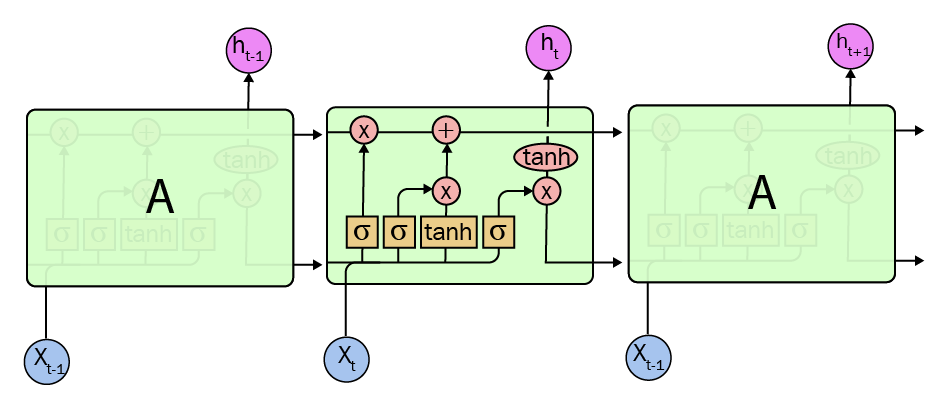

You can see that while the input, **X**, and the output of the hidden layer, (**h**), remain the same, there are different activations that happen in the hidden layer (sigmoid activation in certain cases and tanh activation in others).

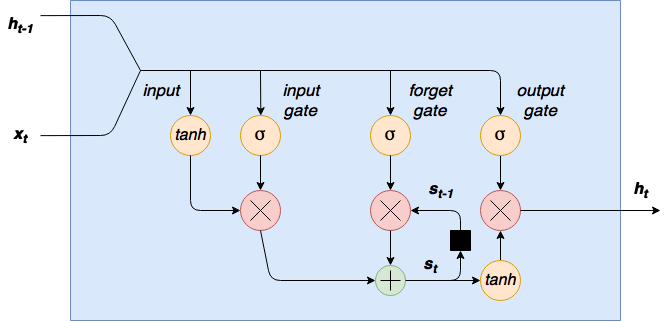

Input=[3 -2 4] ---> tanh(Input)=[tanh(3) tanh(-2) tanh(4)]

Inputgate=[sig(3) sig(-2) sig(4)]=[1 0 1]

tanh(Input)*Inputgate=[tanh(3) 0 tanh(4)]=[1 0 1]


forgetgate=[sig(3) sig(-2) sig(4)]=[1 0 1]

$s_{t-1}$=[5 3 7]

$s_{t-1}*forgetgate$=[5 0 7]

$s_{t}=$s_{t-1}*forgetgate$ + [1 0 1]$ = [6 0 8]

$h_t=[tanh(6)*1 tanh(0)*0 tanh(8)*1]$

(For more infor, see https://adventuresinmachinelearning.com/recurrent-neural-networks-lstm-tutorial-tensorflow/)

**Input gate:** First, the input is squashed between -1 and 1 using a `tanh` activation function. This can be expressed by:

$$g = tanh(b^g + x_tU^g + h_{t-1}V^g)$$

This squashed input is then multiplied element-wise by the output of the input gate. The input gate is basically a hidden layer of sigmoid activated nodes, with weighted $x_t$ and $h_{t-1}$  input values, which outputs values of between 0 and 1 and when multiplied element-wise by the input determines which inputs are switched on and off. In other words, it is a kind of input filter or gate. The expression for the input gate is:

$$i = \sigma(b^i + x_tU^i + h_{t-1}V^i)$$

The output of the input stage of the LSTM cell can be expressed below, where the $\circ$  operator expresses element-wise multiplication:

$$g \circ i$$

**The internal state and the forget gate:** As can be observed, there is a new variable $s_t$ which is the inner state of the LSTM cell. This state is delayed by one-time step and is ultimately added to the $g \circ i$ input to provide an internal recurrence loop to learn the relationship between inputs separated by time. Two things to notice – first, there is a forget gate here – this forget gate is again a sigmoid activated set of nodes which is element-wise multiplied by $c_{t-1}$ (it is $s$ in the picture above) to determine which previous states should be remembered (i.e. forget gate output close to 1) and which should be forgotten (i.e. forget gate output close to 0). This allows the LSTM cell to learn appropriate context. Consider the sentence “Clare took Helen to Paris and she was very grateful” – for the LSTM cell to learn who “she” refers to, it needs to forget the subject “Clare” and replace it with the subject “Helen”. The forget gate can facilitate such operations and is expressed as:

$$f = \sigma(b^f + x_tU^f + h_{t-1}V^f)$$

The output of the element-wise product of the previous state and the forget gate is expressed as $c_{t-1} \circ f$. The output from this stage, $c_t$ is expressed by:

$$c_t = c_{t-1} \circ f + g \circ i$$

**The output gate:** The final stage of the LSTM cell is the output gate. The output gate has two components – another `tanh` squashing function and an output sigmoid gating function. The output sigmoid gating function, like the other gating functions in the cell, is multiplied by the squashed state $c_t$ to determine which values of the state are output from the cell. As you can tell, the LSTM cell is very flexible, with gating functions controlling what is input, what is ``remembered`` in the internal state variable, and finally what is output from the LSTM cell. 

The output gate is expressed as:

$$o = \sigma(b^o + x_tU^o + h_{t-1}V^o)$$

So the final output of the cell can be expressed as:

$$ h_t = tanh(c_t) \circ o$$

This way, we are in a position to leverage the various gates in LSTM to selectively identify the information that needs to be stored in memory and thus overcome the limitation of RNN.

In [1]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.recurrent import SimpleRNN
from keras.layers.embeddings import Embedding
from keras.layers import LSTM
import numpy as np
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
#define documents
docs = ['this is','is an']
# define class labels
labels = ['an','example']


from collections import Counter
counts = Counter()
for i,review in enumerate(docs+labels):
    counts.update(review.split())
words = sorted(counts, key=counts.get, reverse=True)
vocab_size=len(words)
word_to_int = {word: i for i, word in enumerate(words, 1)}

encoded_docs = []
for doc in docs:
    encoded_docs.append([word_to_int[word] for word in doc.split()])
encoded_labels = []
for label in labels:
    encoded_labels.append([word_to_int[word] for word in label.split()])

In [3]:
# pad documents to a max length of 2 words
max_length = 2
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='pre')
print(padded_docs)

[[3 1]
 [1 2]]


In [4]:
# processing the output dataset
one_hot_encoded_labels = to_categorical(encoded_labels, num_classes=5)
print(one_hot_encoded_labels)

[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]]


In [5]:
# define the model
embed_length=1
max_length=2
model = Sequential()
model.add(LSTM(1,activation='tanh', return_sequences=False,recurrent_initializer='Zeros',recurrent_activation='sigmoid',
               input_shape=(max_length,embed_length),unroll=True))
model.add(Dense(5, activation='softmax'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1)                 12        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10        
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________
None


The number of parameters is 12 in the LSTM layer as there are four gates (forget, input, cell, and output), which results in four weights and four biases connecting the input to the hidden layer. Additionally, the recurrent layer contains weight values that correspond to the four gates, which gives us a total of 12 parameters.

The dense layer has a total of 10 parameters as there are five possible classes as output, and thus five weights and five biases that correspond to each connection from the hidden layer to the output layer.

In [7]:
model.fit(padded_docs.reshape(2,2,1),np.array(one_hot_encoded_labels),epochs=500,verbose=0)

In [8]:
model.weights

[<tf.Variable 'lstm_1/kernel:0' shape=(1, 4) dtype=float32, numpy=
 array([[ 1.4747553 ,  0.21844576, -1.6655267 ,  0.3613354 ]],
       dtype=float32)>,
 <tf.Variable 'lstm_1/recurrent_kernel:0' shape=(1, 4) dtype=float32, numpy=
 array([[-0.81191856, -0.97658885,  0.30110872, -1.1714092 ]],
       dtype=float32)>,
 <tf.Variable 'lstm_1/bias:0' shape=(4,) dtype=float32, numpy=array([ 0.8243644 ,  1.6411912 , -0.59207046,  0.8917778 ], dtype=float32)>,
 <tf.Variable 'dense_1/kernel:0' shape=(1, 5) dtype=float32, numpy=
 array([[ 1.7270645 ,  1.8367546 , -0.00402346,  1.3263528 , -0.26260275]],
       dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(5,) dtype=float32, numpy=
 array([-0.6053054 , -0.59397745,  0.6904611 , -0.64862293,  0.5336966 ],
       dtype=float32)>]

From the preceding code (`model.weights`), we can see that the order of weights in the LSTM layer is as follows:

- Weights of the input (kernel)
- Weights corresponding to the hidden layer (recurrent_kernel)
- Bias in the LSTM layer

Similarly, in the dense layer (the layer that connects the hidden layer to the output), the order of weights is as follows:
- Weight to be multiplied with the hidden layer
- Bias

In [13]:
model.get_weights() # the order of weights for kernel is 
# i (input), f (forget), c (cell state) and o (output)

[array([[ 1.4747553 ,  0.21844576, -1.6655267 ,  0.3613354 ]],
       dtype=float32),
 array([[-0.81191856, -0.97658885,  0.30110872, -1.1714092 ]],
       dtype=float32),
 array([ 0.8243644 ,  1.6411912 , -0.59207046,  0.8917778 ], dtype=float32),
 array([[ 1.7270645 ,  1.8367546 , -0.00402346,  1.3263528 , -0.26260275]],
       dtype=float32),
 array([-0.6053054 , -0.59397745,  0.6904611 , -0.64862293,  0.5336966 ],
       dtype=float32)]

In [14]:
padded_docs[0]

array([3, 1], dtype=int32)

In [15]:
model.predict(padded_docs[0].reshape(1,2,1))

array([[0.02806861, 0.02588452, 0.44036642, 0.0376617 , 0.46801886]],
      dtype=float32)

In [16]:
model.get_weights()[0]

array([[ 1.4747553 ,  0.21844576, -1.6655267 ,  0.3613354 ]],
      dtype=float32)

**Step 1:** Update the forget gate in time step 1. This step looks at the input and then provides an estimate of how much of the cell state (memory) known so far is to be forgotten (note the usage of the sigmoid function)

**Forget gate:** $f = \sigma(b^f + x_tU^f + h_{t-1}V^f)$

In [17]:
input_t0 = 3
cell_state0 = 0
forget0 = input_t0*model.get_weights()[0][0][1] + model.get_weights()[2][1]
forget1 = 1/(1+np.exp(-(forget0)))

**Step 2:** Update the cell state based on the updated forget gate. The output of the previous step is being used here to direct the amount of values to be forgotten from the cell state (memory): $c_t = c_{t-1} \circ f + g \circ i$

In [18]:
cell_state1 = forget1 * cell_state0

**Step 3:** Update the input gate value in time step 1. This step gives an estimate of how much new information is to be injected into the cell state based on the current input: $i = \sigma(b^i + x_tU^i + h_{t-1}V^i)$


In [19]:
input_t0_1 = input_t0*model.get_weights()[0][0][0] + model.get_weights()[2][0]
input_t0_2 = 1/(1+np.exp(-(input_t0_1)))

**Step 4:** Update the cell state based on the updated input value. This is the step where the output from the previous step is being used to dictate the amount of information update that is to happen to cell state (memory):

$g = tanh(b^g + x_tU^g + h_{t-1}V^g)$

In [20]:
input_t0_cell1 = input_t0*model.get_weights()[0][0][2] + model.get_weights()[2][2]
input_t0_cell2 = np.tanh(input_t0_cell1)

$g \circ i$

In [21]:
input_t0_cell3 = input_t0_cell2*input_t0_2

$c_t = c_{t-1} \circ f + g \circ i$

In [22]:
input_t0_cell4 = input_t0_cell3 + cell_state1

**Step 5:** Update the output gate. This step provides an estimate of how much information will be conveyed in the current time step (note the usage of the sigmoid function in this regard): $o = \sigma(b^o + x_tU^o + h_{t-1}V^o)$

In [23]:
output_t0_1 = input_t0*model.get_weights()[0][0][3] + model.get_weights()[2][3]
output_t0_2 = 1/(1+np.exp(-output_t0_1))

**Step 6:** Calculate the hidden layer value at time step 1. Note that the final hidden-layer value at a time step is a combination of how much memory and output in the current time step is used to convey for a single time step: $ h_t = tanh(c_t) \circ o$

In [24]:
hidden_layer_1 = np.tanh(input_t0_cell4)*output_t0_2

**Step 7:** Pass the input value at time step 2 and the cell state value going into time step 2

In [25]:
input_t1 = 1
cell_state1 = input_t0_cell4

In [26]:
forget21 = hidden_layer_1*model.get_weights()[1][0][1] + model.get_weights()[2][1] + input_t1*model.get_weights()[0][0][1]
forget_22 = 1/(1+np.exp(-(forget21)))

In [27]:
cell_state2 = cell_state1 * forget_22

In [28]:
input_t1_1 = input_t1*model.get_weights()[0][0][0] + model.get_weights()[2][0] + hidden_layer_1*model.get_weights()[1][0][0]
input_t1_2 = 1/(1+np.exp(-(input_t1_1)))

In [29]:
input_t1_cell1 = input_t1*model.get_weights()[0][0][2] + model.get_weights()[2][2]+ hidden_layer_1*model.get_weights()[1][0][2]
input_t1_cell2 = np.tanh(input_t1_cell1)

In [30]:
input_t1_cell3 = input_t1_cell2*input_t1_2

In [31]:
input_t1_cell4 = input_t1_cell3 + cell_state2

In [32]:
output_t1_1 = input_t1*model.get_weights()[0][0][3] + model.get_weights()[2][3]+ hidden_layer_1*model.get_weights()[1][0][3]
output_t1_2 = 1/(1+np.exp(-output_t1_1))

In [33]:
hidden_layer_2 = np.tanh(input_t1_cell4)*output_t1_2

In [34]:
final_output = hidden_layer_2 * model.get_weights()[3][0] + model.get_weights()[4]

In [35]:
np.exp(final_output)/np.sum(np.exp(final_output))

array([0.0280686 , 0.02588452, 0.44036636, 0.0376617 , 0.4680188 ],
      dtype=float32)

In [36]:
model.predict(padded_docs[0].reshape(1,2,1))

array([[0.02806861, 0.02588452, 0.44036642, 0.0376617 , 0.46801886]],
      dtype=float32)